# Neural & Behavioral Modeling - Week 4 (Exercises)
by 蔡承威 (r06922056@ntu.edu.tw)

In [16]:
%config IPCompleter.greedy=True 
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import *
from tqdm import tqdm

## 1 Replicate exisiting findings/models 
Based on your personal interest, please choose and replicate ONE of the following studies:

1. <a href="http://ccl.northwestern.edu/netlogo/models/FlockingVeeFormations">Flocking Vee Formations</a> in NetLogo's [Sample Models::Biology] 

2. <a href="http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation">Wolf-Sheep Predation</a> in NetLogo's [Sample Models::Biology] 

3. <a href="https://www.wetalk.tw/thread-36278-1-1.html">MIT Matching Game</a>

4. Gray, K., Rand, D. G., Ert, E., Lewis, K., Hershman, S., & Norton, M. I. (2014). <a href="http://www.mpmlab.org/groups/">The emergence of “us and them” in 80 lines of code: Modeling group genesis in homogeneous populations</a>. Psychological Science, 25(4), 982-990.

5. Luhmann, C. C., & Rajaram, S. (2015). <a href="http://journals.sagepub.com/doi/abs/10.1177/0956797615605798">Memory transmission in small groups and large networks: An agent-based model</a>. Psychological Science, 26(12), 1909-1917.

In [2]:
class Agent(object):
    def __init__(self, id, alpha=.2, beta=.05, gama=.75, n_items=40):
        self.id = str(id)
        self.alpha = alpha
        self.beta = beta
        self.gama = gama
        self.n_items = n_items
        self.A = np.ones(self.n_items) / n_items # uniform initialization
        self.S = np.random.rand(self.n_items, self.n_items) * 0.4 - 0.2
        self.retrived_items = set()
        
    def _reduceMax(self):
        max_i = np.argmax(self.A)
        self.A[max_i] += -self.beta * self.A[max_i]
    
    def _reduceMaxAssociate(self):
        max_i = np.argmax(self.A)
        max_asso = list(range(self.n_items))
        max_asso.remove(max_i)
        for j in max_asso:
            self.A[j] += -self.beta * self.S[max_i][j] *self.A[j]
    
    def _increaseTarget(self, i):
        self.A[i] += self.alpha * (1 - self.A[i])
    
    def _increaseTargetAssociate(self, i):
        target_asso = list(range(self.n_items))
        target_asso.remove(i)
        for j in target_asso:
            self.A[j] += self.beta * self.S[i][j] * self.A[j]
        return
    
    def encode(self, i):
        assert(i is not None)
        max_item = np.argmax(self.A)
        if i != max_item:
            self._reduceMax()
            self._reduceMaxAssociate()
        self._increaseTarget(i)
        self.A = self.A / np.sum(self.A)  # normalization
        return
    
    def retrieve(self, latest_retrieved):
        if np.random.binomial(1, p=self.gama) != 1:
            return None
        i = np.random.choice(self.n_items, 1, p=self.A)[0]
        if  i == latest_retrieved:
            return None
        else: # successlly retricve and update memory A
            self._increaseTargetAssociate(i)
            max_item = np.argmax(self.A)
            if i != max_item:
                self._reduceMax()
                self._reduceMaxAssociate()
            self._increaseTarget(i)
            self.A = self.A / np.sum(self.A)  # normalization
            self.retrived_items.update(str(i))
            return i    

In [3]:
n_group = 3
n_rounds = 20
n_items = 40

def conduct_experiment_once(n_group = 3, n_rounds = 20, n_items = 40):
    Agents = [Agent(i) for i in range(n_group)]
    # encoding phase
    encode_list = np.arange(n_items)
    np.random.shuffle(encode_list)
    for a in Agents:
        for i in encode_list:
            a.encode(i)

    # retrieve phase of control
    Agents_control = copy.deepcopy(Agents)
    latest_retrieved = [None] * n_group
    for r in range(n_rounds):
        for i, a in enumerate(Agents_control):
            latest_retrieved[i] = a.retrieve(latest_retrieved[i])

    # retrieve phase of case
    latest_retrieved = None
    for r in range(n_rounds):
        select = np.arange(n_group)
        np.random.shuffle(select)
        for s in select:
            latest_retrieved = Agents[s].retrieve(latest_retrieved)
            if latest_retrieved is not None:
                others = select.tolist()
                others.remove(s)
                for o in others:
                    Agents[o].encode(latest_retrieved)
    return Agents, Agents_control

Agents, Agents_control = conduct_experiment_once()

In [4]:
average_group = 0
nominal_group = set()
for i in range(n_group):
    print(Agents_control[i].retrived_items)
    average_group += len(Agents_control[i].retrived_items)
    nominal_group.update(Agents_control[i].retrived_items)
print('Recall number in average  = {}'.format(average_group / n_group))
print('Nominal Recall = {}'.format(nominal_group))
print('Nominal Recall Number = {}'.format(len(nominal_group)))

{'0', '1', '4', '3'}
{'5', '3', '7', '1', '2'}
{'0', '1', '4', '3'}
Recall number in average  = 4.333333333333333
Nominal Recall = {'5', '3', '7', '0', '1', '4', '2'}
Nominal Recall Number = 7


In [5]:
collaboratvie_group = set()
for i in range(n_group):
    print(Agents[i].retrived_items)
    collaboratvie_group.update(Agents[i].retrived_items)
print('Collaborative Recall = {}'.format(collaboratvie_group))
print('Collaborative Recall Number= {}'.format(len(collaboratvie_group)))

{'9', '3', '7', '0', '1', '4'}
{'9', '3', '7', '1', '4'}
{'9', '3', '7', '0', '1'}
Collaborative Recall = {'9', '3', '7', '0', '1', '4'}
Collaborative Recall Number= 6


# Study 1 - Validating the Agent Model

In [11]:
n_experiment = 1000
n_group = 3
n_rounds = 20
n_items = 40

average_st = [] 
nominal_st = []
collaborative_st = []

for e in tqdm(range(n_experiment)):
    Agents, Agents_control = conduct_experiment_once()
    # control
    average_group = 0
    nominal_group = set()
    for i in range(n_group):
        average_group += len(Agents_control[i].retrived_items)
        nominal_group.update(Agents_control[i].retrived_items)
    # case
    collaboratvie_group = set()
    for i in range(n_group):
        collaboratvie_group.update(Agents[i].retrived_items)
        
    average_st.append(average_group / n_group)
    nominal_st.append(len(nominal_group))
    collaborative_st.append(len(collaboratvie_group))

print('Group Size = {}'.format(n_group))
print('Average Recall = {}'.format(sum(average_st) / n_experiment))
print('Nominal Recall = {}'.format(sum(nominal_st) / n_experiment))
print('Collaberative Recall = {}'.format(sum(collaborative_st) / n_experiment))

100%|██████████| 1000/1000 [00:43<00:00, 22.75it/s]

Group Size = 3
Average Recall = 5.72866666666666
Nominal Recall = 8.056
Collaberative Recall = 6.249


# Study 2- Group Size

In [15]:
min_group_size = 2
max_group_size = 4
average_g = [] 
nominal_g = []
collaborative_g = []

for n in range(min_group_size, max_group_size + 1):
    
    average_st = [] 
    nominal_st = []
    collaborative_st = []
    for e in tqdm(range(n_experiment)):
        Agents, Agents_control = conduct_experiment_once(n_group=n)
        # control
        average_group = 0
        nominal_group = set()
        for i in range(n):
            average_group += len(Agents_control[i].retrived_items)
            nominal_group.update(Agents_control[i].retrived_items)
        # case
        collaboratvie_group = set()
        for i in range(n):
            collaboratvie_group.update(Agents[i].retrived_items)

        average_st.append(average_group / n)
        nominal_st.append(len(nominal_group))
        collaborative_st.append(len(collaboratvie_group))

    average_g.append(sum(average_st) / n_experiment)
    nominal_g.append(sum(nominal_st) / n_experiment)
    collaborative_g.append(sum(collaborative_st) / n_experiment)


  2%|▏         | 20/1000 [00:00<00:27, 36.04it/s]Exception in thread Thread-12:
Traceback (most recent call last):
  File "/Users/Dennis/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/Dennis/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Dennis/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


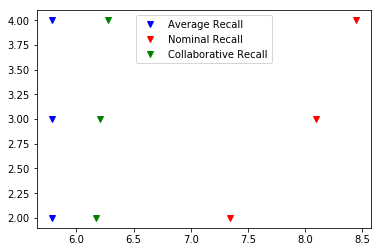

In [18]:
plt.plot(average_g, range(min_group_size, max_group_size + 1), 'bv')
plt.plot(nominal_g, range(min_group_size, max_group_size + 1), 'rv')
plt.plot(collaborative_g, range(min_group_size, max_group_size + 1), 'gv')
plt.legend(['Average Recall','Nominal Recall', 'Collaborative Recall']);